In this notebook I will test several ways of obtaining the correlation function, then I will obtain integrate to get the transport coefficients using Green-Kubo

Test for the autocorrelation function
http://lab.pdebuyl.be/tidynamics/auto_examples/plot_acf_1.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem
from statsmodels.tsa.stattools import acf
import time as t

In [2]:
# Generate data for a Ornstein-Uhlenbeck process
gamma = 2.7
T = 0.1
dt = 0.02
v_factor = np.sqrt(2*T*gamma*dt)

N = 32768
v = 0
for i in range(100):
    noise_force = v_factor*np.random.normal()
    v = v - gamma*v*dt + noise_force

v_data = []
noise_data = []

for i in range(N):
    noise_force = v_factor*np.random.normal()
    v = v - gamma*v*dt + noise_force
    v_data.append(v)
    noise_data.append(noise_force)
v_data = np.array(v_data)
noise_data = np.array(noise_data)/np.sqrt(dt)
time = np.arange(N//64)*dt

# statmodels 
The first method to try is the autocorrelation function from statsmodels, it seems to be very efficient as it uses recursion (when I saw the source code), still need to test the performance for longer datasets. acv is normalised, so we need to get the amplituded, which is computed with np.correlate that is the same as doing np.correlate(v_data,v_data) v_data*v_data. One of the advantages of this method is that it gives an estimate of the confidence, if the alpha option is used in acf. 

A confidence of 95% (alpha = 0.05), is equal to having error bars of 2*standard error

In [19]:
t0 = t.time()
amplitude  = np.correlate(v_data,v_data)/len(v_data)
acf_num, confidence = acf(v_data, nlags = len(time)-1, alpha=0.05)
acf_num = amplitude * acf_num 
confidence = amplitude * confidence
std_error = (acf_num-confidence[:,0])/2 

print ("statmodels took %s"%(t.time()-t0))

statmodels took 0.18302416801452637


# My class (np.cov)
Here I will use the methods from my classes flux and correlation

In [4]:
import sys
import os
sys.path.append('../../../') #This falls into Utilities path
import Lammps.core_functions as cf
from statsmodels.tsa.stattools import acf
import Lammps.Pore.GK.flux_correlation as fc

In [5]:
t1 = t.time()

times = np.arange(0,len(v_data),1)
velocity = fc.flux(v_data , times,"V")
print(np.shape(times),np.shape(v_data))
D = fc.correlation(velocity, velocity, len(time))
D.evaluate()

print ("My class took %s"%(t.time()-t1))

  0%|          | 0/512 [00:00<?, ?it/s]

(32768,) (32768,)


100%|██████████| 512/512 [00:02<00:00, 187.29it/s]


My class took 2.8253209590911865


Text(0, 0.5, '$\\langle v(t) v(t+\\tau) \\rangle$')

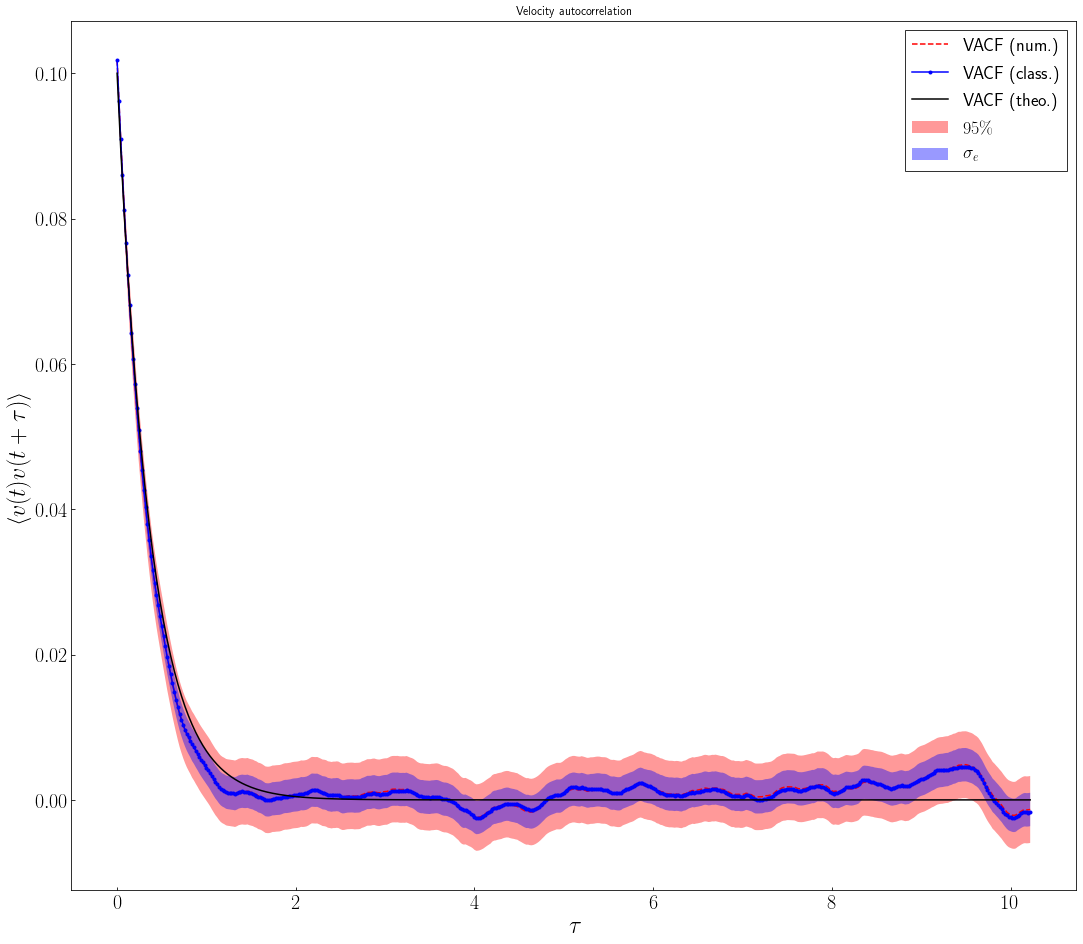

In [22]:
cf.set_plot_appearance()
plt.close('all')
fig,ax = plt.subplots(figsize=(18, 16))
ax.plot(time, acf_num,'--', label='VACF (num.)')
ax.fill_between(time, confidence[:,0], confidence[:,1] ,alpha=0.4, label = r"$95\%$")
ax.fill_between(time, acf_num-std_error, acf_num+std_error ,alpha=0.4, label =r'$\sigma_e$')
ax.plot(time, D.cor[0], '.-', label="VACF (class.)")
ax.plot(time, T*np.exp(-gamma*time), label='VACF (theo.)')
plt.legend(loc = 'upper right')
plt.title('Velocity autocorrelation')
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\langle v(t) v(t+\tau) \rangle$')